In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import sys

from efficientnet_pytorch import EfficientNet
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
import torchvision
from torchvision import datasets, models, transforms

from sklearn.model_selection import GroupKFold, StratifiedKFold
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
BASE_DIR = "../../../data/cassava-leaf-disease-classification"
train_dir = os.path.join(BASE_DIR, 'train_images/')
test_dir = os.path.join(BASE_DIR, "test_images/")
print(train_dir)

../../../data/cassava-leaf-disease-classification\train_images/


In [3]:
#日付を取得
import datetime as dt

dt_now = dt.datetime.now()
directory_name = dt_now.strftime('%Y%m%d%H')
create_directory = BASE_DIR + '/models/' + directory_name
if(not (os.path.exists(create_directory))):
    os.mkdir(create_directory)

In [4]:
## config
class CFG:
    num_workers=0
    model_name='efficientnet-b1'
    size=240
    batch_size=16
    target_size=5
    target_col='label'
    n_fold=3
    seed = 2021
    learning_rate = 1e-5
    num_epochs = 20
    n_split = 3
    checkpoint_thres_loss = 0.1
    checkpoint_thres_acc = 80
    weights=torch.tensor([0.50, 1.0, 1.1, 6.1, 1.2]) #see 000_EDA.ipynb

In [5]:
np.random.seed(CFG.seed)
random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed(CFG.seed)

In [6]:
df_train = pd.read_csv(BASE_DIR + "/train.csv")
df_train.head()


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [7]:

model = EfficientNet.from_pretrained(CFG.model_name)
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, CFG.target_size)

Loaded pretrained weights for efficientnet-b1


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

cuda:0
GeForce RTX 2060
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [9]:
data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(240),
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [10]:
class ImageData(Dataset):
    def __init__(self, df, data_dir, transform, output_label=True):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.output_label = output_label

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):       
        img_name = self.df.iloc[index,0]
        if self.output_label:
            label = self.df.iloc[index,1]
        
        img_path = os.path.join(self.data_dir, img_name)
        image = plt.imread(img_path)
        image = self.transform(image)

        # do label smoothing
        if self.output_label == True:
            return image, label
        else:
            return image

In [11]:
def Plot_Model_History(loss_tra_li,acc_tra_li,loss_val_li,acc_val_li):
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 2, 1)
    plt.plot(loss_tra_li, label="train_loss")
    plt.plot(loss_val_li, label="val_loss")
    plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(acc_tra_li, label="train_acc")
    plt.plot(acc_val_li, label="val_acc")
    plt.legend()
    plt.show()
    
def Save_histroy(init=False):
    filename = "./log/" + directory_name
    if init:
        with open(filename+'.txt','w') as f:
            f.write("model: {}, lr: {}, weights: {}. batchsize: {}, kfold: {}, epoch: {}\n" .format(CFG.model_name,CFG.learning_rate,CFG.weights, CFG.batch_size,CFG.n_split,CFG.num_epochs))
    else:
        with open(filename+'.txt',mode='a') as f:
            f.write('\nkfold: {}, epoch: {}. train_loss: {}, train_acc: {}. val_loss: {}, val_acc: {}' .format(fold_index+1, epoch + 1, train_loss, train_acc, val_loss, val_acc))

Loaded pretrained weights for efficientnet-b1
Kfold: 1 - Epoch: 1 - Train_Loss: 0.681025 - Train_Acc: 62.0233 - Val_Loss: 0.360149 - Val_Acc: 66.690032
Kfold: 1 - Epoch: 2 - Train_Loss: 0.306154 - Train_Acc: 67.0429 - Val_Loss: 0.292860 - Val_Acc: 70.138792
Kfold: 1 - Epoch: 3 - Train_Loss: 0.265558 - Train_Acc: 69.4966 - Val_Loss: 0.264792 - Val_Acc: 72.886583
Kfold: 1 - Epoch: 4 - Train_Loss: 0.242376 - Train_Acc: 72.2308 - Val_Loss: 0.243302 - Val_Acc: 75.886724
Kfold: 1 - Epoch: 5 - Train_Loss: 0.213314 - Train_Acc: 75.0631 - Val_Loss: 0.231441 - Val_Acc: 78.620496
Kfold: 1 - Epoch: 6 - Train_Loss: 0.197242 - Train_Acc: 77.4537 - Val_Loss: 0.219162 - Val_Acc: 79.629889
Kfold: 1 - Epoch: 7 - Train_Loss: 0.178955 - Train_Acc: 79.2555 - Val_Loss: 0.214087 - Val_Acc: 80.274779
Kfold: 1 - Epoch: 8 - Train_Loss: 0.166286 - Train_Acc: 80.4823 - Val_Loss: 0.211421 - Val_Acc: 81.073882
Kfold: 1 - Epoch: 9 - Train_Loss: 0.152319 - Train_Acc: 81.4358 - Val_Loss: 0.211134 - Val_Acc: 81.550540


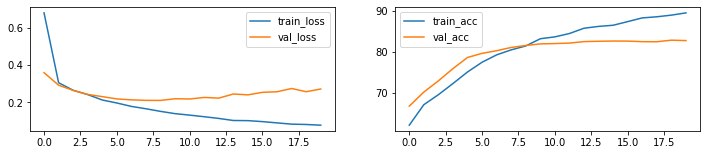

Loaded pretrained weights for efficientnet-b1
Kfold: 2 - Epoch: 1 - Train_Loss: 0.675598 - Train_Acc: 60.7781 - Val_Loss: 0.353631 - Val_Acc: 66.993831
Kfold: 2 - Epoch: 2 - Train_Loss: 0.314050 - Train_Acc: 66.2601 - Val_Loss: 0.288289 - Val_Acc: 68.788559
Kfold: 2 - Epoch: 3 - Train_Loss: 0.270314 - Train_Acc: 68.8048 - Val_Loss: 0.253127 - Val_Acc: 72.069546
Kfold: 2 - Epoch: 4 - Train_Loss: 0.239435 - Train_Acc: 72.0505 - Val_Loss: 0.230863 - Val_Acc: 75.687044
Kfold: 2 - Epoch: 5 - Train_Loss: 0.218325 - Train_Acc: 74.8335 - Val_Loss: 0.210489 - Val_Acc: 78.238923
Kfold: 2 - Epoch: 6 - Train_Loss: 0.196286 - Train_Acc: 77.3782 - Val_Loss: 0.203761 - Val_Acc: 79.641054
Kfold: 2 - Epoch: 7 - Train_Loss: 0.181608 - Train_Acc: 78.9765 - Val_Loss: 0.199339 - Val_Acc: 80.734717
Kfold: 2 - Epoch: 8 - Train_Loss: 0.168419 - Train_Acc: 80.1823 - Val_Loss: 0.196694 - Val_Acc: 81.575996
Kfold: 2 - Epoch: 9 - Train_Loss: 0.155758 - Train_Acc: 81.1847 - Val_Loss: 0.194522 - Val_Acc: 82.136848


KeyboardInterrupt: 

In [12]:
# n_splitsでKの数を指定
folds = StratifiedKFold(n_splits=CFG.n_split).split(np.arange(df_train.shape[0]), df_train["label"].values)
Save_histroy(init=True)
for fold_index, (train_index,val_index) in enumerate(folds):
    model = EfficientNet.from_pretrained(CFG.model_name)
    num_ftrs = model._fc.in_features
    model._fc = nn.Linear(num_ftrs, CFG.target_size)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate)
    
    train = df_train.iloc[train_index].reset_index(drop=True)
    train_data = ImageData(df = train, data_dir = train_dir, transform = data_transforms)
    train_loader = DataLoader(dataset = train_data, batch_size = CFG.batch_size, num_workers=CFG.num_workers, pin_memory=True,shuffle=True)
    train_criterion = nn.CrossEntropyLoss(weight=CFG.weights).to(device)
    
    val = df_train.iloc[val_index,:].reset_index(drop=True)
    val_data = ImageData(df = val, data_dir = train_dir, transform = data_transforms)
    val_loader = DataLoader(dataset = val_data, batch_size = CFG.batch_size, num_workers=CFG.num_workers, pin_memory=True,shuffle=True)
    val_criterion = nn.CrossEntropyLoss(weight=CFG.weights).to(device)
    train_epoch_log = []
    train_acc_log = []
    val_epoch_log = []
    val_acc_log = []
    
    for epoch in range(CFG.num_epochs):
        train_total = 0
        train_correct = 0
        train_loss_sum = 0
        val_total = 0
        val_correct = 0
        val_loss_sum = 0
        
        # train
        model.train()
        for idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = train_criterion(output, target)
            loss.backward()
            optimizer.step()  
            
            train_loss_sum += loss.item()
            train_total += target.size(0)
            _,predicted = output.max(1)
            train_correct += predicted.eq(target).sum().item()

            
        train_loss = train_loss_sum / len(train_loader)
        train_epoch_log.append(train_loss)
        train_acc = 100.0 * train_correct/train_total
        train_acc_log.append(train_acc)
        
        # val
        model.eval()
        with torch.no_grad():
            for idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = val_criterion(output, target)
                val_loss_sum += loss.item()
                val_total += target.size(0)
                _,predicted = output.max(1)
                val_correct += (predicted == target).sum().item()
                    
            val_loss = val_loss_sum / len(val_loader)
            val_epoch_log.append(val_loss)
            val_acc = 100.0 * val_correct/val_total
            val_acc_log.append(val_acc)
                
        print('Kfold: {} - Epoch: {} - Train_Loss: {:.6f} - Train_Acc: {:.4f} - Val_Loss: {:.6f} - Val_Acc: {:4f}'.format(fold_index+1, epoch + 1, train_loss, train_acc, val_loss, val_acc))
        Save_histroy(init=False)
        if (val_loss < CFG.checkpoint_thres_loss) & (val_acc > CFG.checkpoint_thres_acc):
            CFG.checkpoint_thres_loss = val_loss
            CFG.checkpoint_thres_acc = val_acc
            path = create_directory + "./efficientb1_epoch"+str(epoch)+ "_Acc_" + str(val_acc) + '.pth'
            torch.save(model.state_dict(), path) 
        
    Plot_Model_History(train_epoch_log,train_acc_log,val_epoch_log,val_acc_log)